# Handwritten Signature Verification
This project uses a Siamese Neural Network to verify whether a pair of handwritten signatures are from the same person. The model is trained on the CEDAR signature dataset.

## 1. Importing Required Libraries

In [ ]:
import os

In [ ]:
def get_pairs(dir):
    peopledir=dir
    people=os.listdir(peopledir)
    if len(people) > 90:
        people = people[:55]
    data = []
    for i in people:
        person = os.listdir(peopledir+'/'+i)
        genuine=[]
        for j in person:
            if "G" in j or "original" in j :
                genuine.append(j)
        for k in genuine:
            for l in person:
                if k==l:
                    continue
                if 'G' in l or 'original' in l:
                    data.append((k,l,0,i))
                else:
                    data.append((k,l,1,i))
    return data

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as ops
def euclidean_distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss
def load_pairs_train_from_csv(df, input_shape,dir):
    pairs = []
    labels = []
    count=0
    for _, row in df.iterrows():
        img1 = preprocess_image(dir+'/'+row[3]+'/'+row[0], input_shape)
        img2 = preprocess_image(dir+'/'+row[3]+'/'+row[1], input_shape)
        pairs.append([img1, img2])
        labels.append(row[2])
    return np.array(pairs), np.array(labels)
def preprocess_image(image_path, input_shape):
    img = load_img(image_path, target_size=input_shape[:2], color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return img_array

## 2. Load Dataset

In [ ]:
data=get_pairs('/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/')

### Convert to DataFrame

In [ ]:
import pandas as pd
df=pd.DataFrame(data,columns=['img1','img2','label','person'])
df

,img1,img2,label,person
0,original_7_18.png,forgeries_7_7.png,1,7
1,original_7_18.png,forgeries_7_5.png,1,7
2,original_7_18.png,forgeries_7_9.png,1,7
3,original_7_18.png,original_7_6.png,0,7
4,original_7_18.png,original_7_24.png,0,7
...,...,...,...,...
62035,original_24_17.png,forgeries_24_1.png,1,24
62036,original_24_17.png,forgeries_24_12.png,1,24
62037,original_24_17.png,forgeries_24_19.png,1,24
62038,original_24_17.png,forgeries_24_4.png,1,24


### Check Dataset Shape

In [ ]:
df.shape

(62040, 4)

## 3. Preprocessing

In [ ]:
input_shape = (105, 105, 1)
dir='/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR'
train_pairs, train_labels = load_pairs_train_from_csv(df, input_shape,dir)

/tmp/ipykernel_23/2133285894.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img1 = preprocess_image("/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/"+'/'+row[3]+'/'+row[0], input_shape)
/tmp/ipykernel_23/2133285894.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img2 = preprocess_image("/kaggle/input/handwritten-signature-datasets/CEDAR/CEDAR/"+'/'+row[3]+'/'+row[1], input_shape)
/tmp/ipykernel_23/2133285894.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_pairs, train_labels, test_size=0.2, random_state=42,shuffle=True)

In [ ]:
x_train_1 = X_train[:, 0]
x_train_2 = X_train[:, 1]
x_test_1 = X_test[:, 0]
x_test_2 = X_test[:, 1]

## 4. Build Siamese Neural Network

In [ ]:
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [ ]:
input = keras.layers.Input((105, 105, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(32, (3, 3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)
embedding_network = keras.Model(input, x)
input_1 = keras.layers.Input((105, 105, 1))
input_2 = keras.layers.Input((105, 105, 1))
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
siamese.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_32      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_41       │ (None, 36864)     │     18,820 │ input_layer_31[0… │
│ (Functional)        │                   │            │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 1)         │          0 │ functional_41[0]… │
│                     │                   │            │ functional_41[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,826 (73.54 KB)

 Trainable params: 18,822 (73.52 KB)

 Non-trainable params: 4 (16.00 B)

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    y_train,
    validation_split = 0.2,
    batch_size=32,
    epochs=5,
)

Epoch 1/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9670 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 4.0759e-04
Epoch 2/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9959 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 3.0620e-04
Epoch 3/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9976 - loss: 0.0023 - val_accuracy: 0.9983 - val_loss: 0.0016
Epoch 4/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9982 - loss: 0.0014 - val_accuracy: 0.9969 - val_loss: 0.0025
Epoch 5/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9985 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 7.8396e-06


In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], y_test)
print("test loss, test acc:", results)

388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 1.2492e-05
test loss, test acc: [1.2621333553397562e-05, 1.0]


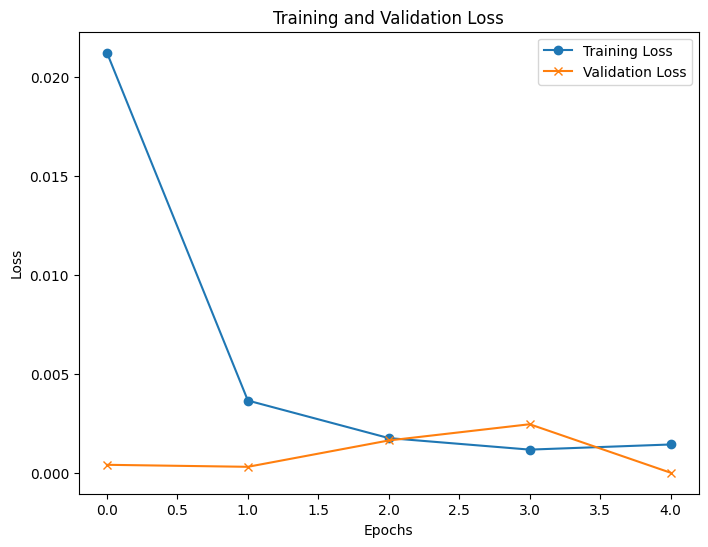

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

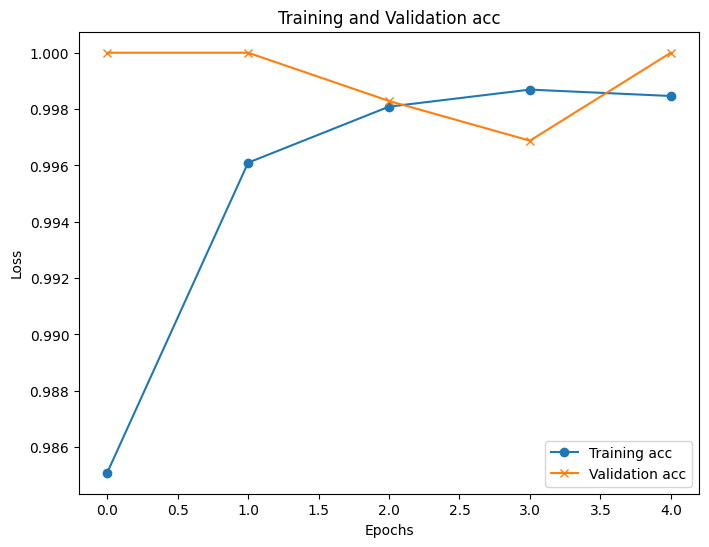

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation acc', marker='x')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()